In [ ]:
pip install tensorflow


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
import os

def build_model(base_filters=32, dense_nodes=128):
    """
    Builds a CNN model with dynamic filters and dense nodes.
    
    Args:
        base_filters (int): Number of filters for the first Conv2D layer. Subsequent layers double the filters.
        dense_nodes (int): Number of nodes in the dense layer.
    
    Returns:
        model (tf.keras.Model): Compiled CNN model.
    """
    model = models.Sequential([
        layers.Conv2D(base_filters, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(base_filters * 2, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(base_filters * 4, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(dense_nodes, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(train_generator.num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=optimizers.Adam(learning_rate=1e-4),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Dataset paths
dataset_dir = "./TankFrames"     #add the directory path.
train_dir = os.path.join(dataset_dir, "train")
test_dir = os.path.join(dataset_dir, "test")

# Check if directories exist
if not os.path.exists(train_dir) or not os.path.exists(test_dir):
    print("Train or Test directory not found. Please check the paths.")
    exit()

# Image dimensions and batch size
IMG_HEIGHT, IMG_WIDTH = 128, 128
BATCH_SIZE = 32

# Data Augmentation and Generators
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

# Define Model Parameters
BASE_FILTERS = 32  # Number of filters in the first Conv2D layer
DENSE_NODES = 128  # Number of nodes in the dense layer

# Build and Train the Model
model = build_model(base_filters=BASE_FILTERS, dense_nodes=DENSE_NODES)

EPOCHS = 3
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=test_generator.samples // BATCH_SIZE
)

# Evaluate the Model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Save the Model
model.save("tank_cnn_dynamic.h5")
print("Model saved as tank_cnn_dynamic.h5")


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
import os

# Dataset paths
dataset_dir = "./TankFrames"  # Change this to your dataset path
train_dir = os.path.join(dataset_dir, "train")
test_dir = os.path.join(dataset_dir, "test")

# Check if directories exist
if not os.path.exists(train_dir) or not os.path.exists(test_dir):
    print("Train or Test directory not found. Please check the paths.")
    exit()

# Image dimensions and batch size
IMG_HEIGHT, IMG_WIDTH = 224, 224  # ResNet50 input size
BATCH_SIZE = 32

# Data Augmentation and Generators
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode="nearest"
)

test_datagen = ImageDataGenerator(rescale=1.0 / 255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

# Load Pretrained ResNet50 Model (without the top classification layer)
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Freeze the base model so only the new layers are trained
base_model.trainable = False

# Build the Model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(train_generator.num_classes, activation="softmax")
])

# Compile the Model
model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

# Train the Model
EPOCHS = 3
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    validation_steps=test_generator.samples // BATCH_SIZE
)

# Evaluate the Model
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Save the Model
model.save("resnet50_tanks_model.h5")
print("Model saved as resnet50_tanks_model.h5")


In [ ]:
#Imagenet-GradCam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, InceptionV3
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model

# Step 1: Define the image file path (update with your image path)
img_file_name = 'C:\\Users\\ram_k\\Downloads\\Abrams_X_1.jpg' # Replace with your image file path

# Step 2: Load and preprocess the image
img = image.load_img(img_file_name, target_size=(299, 299))  # InceptionV3 requires 299x299 input
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)

# Step 3: Load the InceptionV3 model with pre-trained ImageNet weights
model = InceptionV3(weights='imagenet')

# Step 4: Function to compute Grad-CAM
def get_gradcam_heatmap(model, img_array, class_index=None):
    grad_model = Model(
        inputs=model.input,
        outputs=[model.get_layer("mixed10").output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(np.array(img_array))
        if class_index is None:
            class_index = np.argmax(preds[0])  # If no class_index, choose the highest predicted class
        loss = preds[:, class_index]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    heatmap = conv_outputs[0] @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

# Step 5: Get the heatmap for the highest predicted class
heatmap = get_gradcam_heatmap(model, img_array)

# Resize the heatmap to the size of the original image
heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))

# Increase the heatmap intensity to highlight the red regions more
heatmap = heatmap * 3  # Increase the intensity (you can adjust this value to make it more pronounced)

# Clip the heatmap to avoid out-of-bound values
heatmap = np.clip(heatmap, 0, 1)

# Calculate the region to cover the entire image (no specific region like a tank)
height, width = img.size[1], img.size[0]
# Set the region to the entire image
tank_region = (0, 0, width, height)

# Define the top-left and bottom-right corners of the rectangle for the mask
top_left = (tank_region[0], tank_region[1])
bottom_right = (tank_region[2], tank_region[3])

# Create a rectangular mask that highlights the entire image
mask = np.zeros((height, width), dtype=np.uint8)

# Draw the rectangle on the mask (covering the entire image)
cv2.rectangle(mask, top_left, bottom_right, 255, -1)  # 255 for white color, -1 to fill the rectangle

# Apply the mask to the heatmap
masked_heatmap = cv2.bitwise_and(heatmap, heatmap, mask=mask)

# Normalize the heatmap for blending
masked_heatmap = np.uint8(250 * (masked_heatmap / np.max(masked_heatmap)))
masked_heatmap = cv2.applyColorMap(masked_heatmap, cv2.COLORMAP_JET)

# Overlay the masked heatmap on the original image
original_img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)  # Convert to BGR for OpenCV
overlay = cv2.addWeighted(original_img, 0.6, masked_heatmap, 0.4, 0)

# Display the original image and the modified Grad-CAM heatmap overlay
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))  # Show original image
plt.axis('off')
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))  # Show overlay image
plt.axis('off')
plt.title("Grad-CAM Heatmap Overlay (Full Image)")

plt.show()


In [ ]:
#ImageNet-LIME
import numpy as np
import keras
from keras.applications.imagenet_utils import decode_predictions
import skimage.io
import skimage.segmentation
import skimage.transform
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Step 2: Define your image path
img_path = 'C:\\Users\\ram_k\\Downloads\\Abrams_X_1.jpg'  # Replace with your actual image path

# Step 3: Read and preprocess the image
Xi = skimage.io.imread(img_path)
Xi = skimage.transform.resize(Xi, (299, 299))  # Resize for InceptionV3 model input
Xi = (Xi - 0.5) * 2  # Inception preprocessing

# Show the selected image after preprocessing
plt.imshow(Xi / 2 + 0.5)
plt.title(f"Preprocessed Image: {img_path}")
plt.show()

# Step 5: Load pretrained InceptionV3 model
inceptionV3_model = keras.applications.inception_v3.InceptionV3()

# Step 6: Predict the class of the uploaded image
preds = inceptionV3_model.predict(Xi[np.newaxis, :, :, :])
print("Top 5 Predictions:")
for pred in decode_predictions(preds, top=5)[0]:
    print(f"{pred[1]}: {pred[2]:.2f}")

# Step 7: Perform superpixel segmentation
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4, max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]

# Show the image with superpixels outlined
plt.imshow(skimage.segmentation.mark_boundaries(Xi / 2 + 0.5, superpixels))
plt.title("Superpixel Segmentation")
plt.show()

# Step 8: Generate perturbations of the image
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))

# Define a function to perturb the image
def perturb_image(img, perturbation, segments):
    active_pixels = np.where(perturbation == 1)[0]
    mask = np.zeros(segments.shape)
    for active in active_pixels:
        mask[segments == active] = 1
    perturbed_image = copy.deepcopy(img)
    perturbed_image = perturbed_image * mask[:, :, np.newaxis]
    return perturbed_image

# Example of perturbed image
plt.imshow(perturb_image(Xi / 2 + 0.5, perturbations[0], superpixels))
plt.title("Example Perturbed Image")
plt.show()

# Step 9: Get predictions for perturbed images
predictions = []
for pert in perturbations:
    perturbed_img = perturb_image(Xi, pert, superpixels)
    pred = inceptionV3_model.predict(perturbed_img[np.newaxis, :, :, :])
    predictions.append(pred)

predictions = np.array(predictions)

# Step 10: Calculate distances from original image
original_image = np.ones(num_superpixels)[np.newaxis, :]
distances = sklearn.metrics.pairwise_distances(perturbations, original_image, metric='cosine').ravel()

# Step 11: Apply kernel function and weights
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances ** 2) / kernel_width ** 2))

# Step 12: Fit a simpler linear model
class_to_explain = preds[0].argsort()[-1]  # Top class
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:, :, class_to_explain], sample_weight=weights)

# Step 13: Extract feature coefficients
coeff = simpler_model.coef_[0]
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:]

# Step 14: Create mask for top superpixels and display
mask = np.zeros(num_superpixels)
mask[top_features] = True

plt.imshow(perturb_image(Xi / 2 + 0.5, mask, superpixels))
plt.title("Top Features Highlighted")
plt.show()


In [ ]:
#RESNET-LIME
# Step 1: Import necessary libraries
!pip install keras tensorflow scikit-image sklearn

import numpy as np
import keras
from keras.models import load_model
from keras.applications.resnet50 import preprocess_input
import skimage.io
import skimage.segmentation
import skimage.transform
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

# Step 2: Provide the image path (set this to your desired image path)
img_path = "C:\\Users\\ram_k\\Downloads\\Abrams_X_1.jpg"  # Replace with the actual path to your image

# Step 3: Read the image and preprocess
Xi = skimage.io.imread(img_path)
Xi = skimage.transform.resize(Xi, (224, 224))  # Resize for ResNet50 model input

# Save a copy of the original image for display purposes
Xi_original = Xi.copy()

# Preprocess the image for ResNet50
Xi = preprocess_input(Xi)

# Show the original image after resizing
plt.imshow(Xi_original)
plt.axis('off')
plt.title("Original Image (Resized)")
plt.show()

# Step 4: Load your custom fine-tuned ResNet50 model
model_path = r"C:\Users\ram_k\Downloads\resnet50_tanks_model.h5"
resnet50_model = load_model(model_path)

# Step 5: Predict the class of the uploaded image
preds = resnet50_model.predict(Xi[np.newaxis, :, :, :])

# Step 6: Identify top predicted classes
class_labels = ['Abrams_X', 'Arjun', 'Leopard_2', 'Stryker']  # Replace this with your actual class labels
top_pred_classes = preds[0].argsort()[-5:][::-1]

print("Top 5 Predictions:")
for i in top_pred_classes:
    print(f"Class: {class_labels[i]}, Probability: {preds[0][i]}")

# Step 7: Perform superpixel segmentation
superpixels = skimage.segmentation.quickshift(Xi_original, kernel_size=4, max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]

# Show the image with superpixels outlined
plt.imshow(skimage.segmentation.mark_boundaries(Xi_original, superpixels))
plt.axis('off')
plt.title("Superpixel Segmentation")
plt.show()

# Step 8: Generate perturbations of the image
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))

# Define a function to perturb the image
def perturb_image(img, perturbation, segments):
    mask = np.zeros(segments.shape)
    active_pixels = np.where(perturbation == 1)[0]
    for active in active_pixels:
        mask[segments == active] = 1
    perturbed_image = copy.deepcopy(img)
    perturbed_image[mask == 0] = 0  # Set masked-out regions to black
    return perturbed_image

# Example of perturbed image
perturbed_img = perturb_image(Xi_original, perturbations[0], superpixels)
plt.imshow(perturbed_img)
plt.axis('off')
plt.title("Example of Perturbed Image")
plt.show()

# Step 9: Get predictions for perturbed images
predictions = []
for pert in perturbations:
    perturbed_img = perturb_image(Xi, pert, superpixels)
    pred = resnet50_model.predict(perturbed_img[np.newaxis, :, :, :])
    predictions.append(pred)

predictions = np.array(predictions)

# Step 10: Calculate distances from original image
original_image = np.ones(num_superpixels)[np.newaxis, :]
distances = sklearn.metrics.pairwise_distances(perturbations, original_image, metric='cosine').ravel()

# Step 11: Apply kernel function and weights
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances ** 2) / kernel_width ** 2))

# Step 12: Fit a simpler linear model
class_to_explain = top_pred_classes[0]
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:, :, class_to_explain], sample_weight=weights)

# Step 13: Extract feature coefficients
coeff = simpler_model.coef_[0]
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:]

# Step 14: Create mask for top superpixels and display
mask = np.zeros(num_superpixels)
mask[top_features] = True

# Display the masked image
masked_img = perturb_image(Xi_original, mask, superpixels)
plt.imshow(masked_img)
plt.axis('off')
plt.title("Image Highlighting Top Superpixels")
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


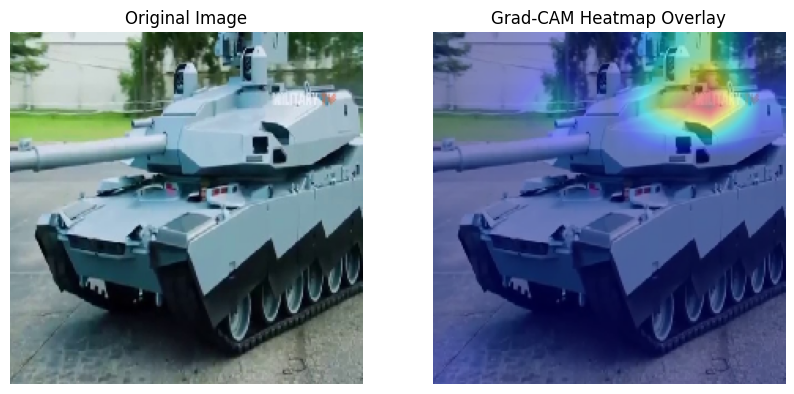

In [1]:
#Resnet-GradCam
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

# Step 1: Specify the path to the image file
img_file_name = "C:\\Users\\ram_k\\Downloads\\Abrams_X_1.jpg"  # Replace with the actual path to your image file

# Step 2: Load and preprocess the image
img = image.load_img(img_file_name, target_size=(224, 224))  # ResNet50 requires 224x224 input
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = tf.keras.applications.resnet50.preprocess_input(img_array)

# Step 3: Load your custom model
model_path = "C:\\Users\\ram_k\\Downloads\\resnet50_tanks_model.h5" # Replace with the actual path to your model file
model = load_model(model_path)

# Step 4: Make predictions
predictions = model.predict(img_array)
top_label = np.argmax(predictions[0])

# Step 5: Define the Grad-CAM function
def get_gradcam_heatmap(model, img_array, class_index, last_conv_layer_name="conv5_block3_out"):
    grad_model = tf.keras.models.Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel by the corresponding importance weight
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    # Normalize the heatmap between 0 and 1 for visualization
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    heatmap = heatmap.numpy()
    return heatmap

# Step 6: Get the heatmap for the top label
heatmap = get_gradcam_heatmap(model, img_array, top_label)

# Step 7: Resize the heatmap to the size of the original image
heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))

# Step 8: Convert the heatmap to a color map
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# Step 9: Load the original image for overlay
original_img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)

# Step 10: Overlay the heatmap on the original image
overlay = cv2.addWeighted(original_img, 0.6, heatmap, 0.4, 0)

# Step 11: Display the original image and Grad-CAM heatmap overlay
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Grad-CAM Heatmap Overlay")

plt.show()


In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from lime.lime_image import LimeImageExplainer
from skimage.segmentation import slic, mark_boundaries
from skimage.color import gray2rgb
import matplotlib.pyplot as plt
import os

# Step 1: Define image paths
image_paths = [
       'C:\\Users\\ram_k\\Downloads\\Abrams_X_1.jpg'
]

# Step 2: Load your fine-tuned CNN model (replace with your actual model path)
model_path = r"C:\Users\ram_k\Downloads\tank_cnn_from_scratch (1).h5"  # Update with your model's path
model = load_model(model_path)

# Step 3: Define the class names (ensure these are correct for your model)
class_names = ["Abrams_X", "Arjun", "Leopard_2", "Stryker"]

# Step 4: Function to preprocess the image
def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(128, 128))  # Resize to the model's input size
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize the image (same as during training)
    return img, img_array

# Step 5: Define Model Wrapper for LIME
class ModelWrapper:
    def __init__(self, model):
        self.model = model

    def predict(self, x):
        return self.model.predict(x)

# Initialize LIME Explainer
explainer = LimeImageExplainer()

# Step 6: Process each image
for img_path in image_paths:
    if not os.path.exists(img_path):
        print(f"Image not found: {img_path}")
        continue

    print(f"Processing image: {img_path}")

    # Preprocess the image
    img, img_array = preprocess_image(img_path)

    # Wrap the model
    wrapped_model = ModelWrapper(model)

    # Generate LIME explanation with 150 superpixels using SLIC segmentation
    explanation = explainer.explain_instance(
        img_array[0], wrapped_model.predict, top_labels=5, hide_color=0, num_samples=1000,
        segmentation_fn=lambda x: slic(x, n_segments=150, compactness=10)
    )

    # Extract explanation image and mask
    explanation_image, mask = explanation.get_image_and_mask(
        explanation.top_labels[0], positive_only=True, num_features=10, hide_rest=False
    )

    # Display the original image
    plt.figure(figsize=(15, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(image.load_img(img_path))
    plt.title(f"Original Image: {class_names[np.argmax(model.predict(img_array))]}")

    # Display the explanation with superpixels
    plt.subplot(1, 3, 2)
    plt.imshow(mark_boundaries(explanation_image, mask))
    plt.title("LIME Explanation")

    # Extract the yellow-bounded regions
    original_img = np.array(image.load_img(img_path, target_size=(128, 128)))
    if len(original_img.shape) == 2:  # Convert grayscale to RGB
        original_img = gray2rgb(original_img)
    extracted_region = np.zeros_like(original_img)
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i, j] > 0:  # Highlighted region
                extracted_region[i, j] = original_img[i, j]

    # Display the extracted regions
    plt.subplot(1, 3, 3)
    plt.imshow(extracted_region)
    plt.title("Extracted Highlighted Regions")
    plt.axis("off")

    plt.show()

    


In [ ]:
#CNN-GRADCAM
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model

# Step 1: Load your trained CNN model
model = tf.keras.models.load_model("tank_cnn_dynamic.h5")

# Find the last convolutional layer dynamically
last_conv_layer_name = None
for layer in reversed(model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv_layer_name = layer.name
        break

if last_conv_layer_name is None:
    raise ValueError("No convolutional layer found in the model.")

print(f"Using last convolutional layer: {last_conv_layer_name}")

# Step 2: Define the image file path (update with your image path)
img_file_name = 'C:\\Users\\ram_k\\Downloads\\Abrams_X_1.jpg'  # Update your image path

# Step 3: Load and preprocess the image (Ensure it matches training settings)
IMG_HEIGHT, IMG_WIDTH = 128, 128  # Use the size from training
img = image.load_img(img_file_name, target_size=(IMG_HEIGHT, IMG_WIDTH))
img_array = image.img_to_array(img) / 255.0  # Normalize as done in training
img_array = np.expand_dims(img_array, axis=0)

# Step 4: Function to compute Grad-CAM
def get_gradcam_heatmap(model, img_array, class_index=None):
    grad_model = Model(
        inputs=model.input,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, preds = grad_model(img_array)
        if class_index is None:
            class_index = np.argmax(preds[0])  # If no class_index, use top predicted class
        loss = preds[:, class_index]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))
    heatmap = conv_outputs[0] @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.reduce_max(heatmap)
    return heatmap.numpy()

# Step 5: Get the heatmap for the highest predicted class
heatmap = get_gradcam_heatmap(model, img_array)

# Resize heatmap to match the original image size
heatmap = cv2.resize(heatmap, (img.size[0], img.size[1]))
heatmap = np.clip(heatmap * 3, 0, 1)  # Increase intensity

# Overlay Grad-CAM heatmap onto the image
masked_heatmap = np.uint8(250 * (heatmap / np.max(heatmap)))
masked_heatmap = cv2.applyColorMap(masked_heatmap, cv2.COLORMAP_JET)

original_img = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)  # Convert to BGR for OpenCV
overlay = cv2.addWeighted(original_img, 0.6, masked_heatmap, 0.4, 0)

# Display results
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Original Image")

plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(overlay, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Grad-CAM Heatmap Overlay")

plt.show()
